# Classification of genre - logistic regression and hierarchical model

For the purpose of this project in the course 42186 Model-based machine learning F19 , we have chosen to work with data from Spotify. We have extracted the data ourselves using the Spotipy Python library inspired by the Kaggle data set (https://www.kaggle.com/nadintamer/top-tracks-of-2017/version/1). We have around 6000 observations consisting of random tracks from official playlists from 2017, 2018 and 2019 (four first months), respectively. Each song has a set of audio features, including popularity danceability, energy, tempo, key, etc., and this leads us to our research question:

### Research question
How can audio features be used to predict the genre of a track?

Importing required libraries:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Loading data:

In [4]:
#### pop = 1 ####
pop1 = pd.read_csv("SpotifyAudioFeatures2017.csv")
pop2 = pd.read_csv("SpotifyAudioFeatures2018.csv")
pop3 = pd.read_csv("SpotifyAudioFeatures2019.csv")
df_pop = pd.concat([pop1, pop2,pop3])
df_pop["genre"] = [1]*len(df_pop)

#### metal = 2 ####
met1 = pd.read_csv("SpotifyAudioFeatures2017metal.csv")
met2 = pd.read_csv("SpotifyAudioFeatures2018metal.csv")
met3 = pd.read_csv("SpotifyAudioFeatures2019metal.csv")
df_met = pd.concat([met1, met2, met3])
#df_met = pd.read_csv("SpotifyAudioFeatures201720182019metal.csv")
df_met["genre"] = [2]*len(df_met)

#### classical = 3 ####
df_clas = pd.read_csv("SpotifyAudioFeaturesclassical.csv")
df_clas["genre"] = [3]*len(df_clas)

#### rap = 4 ####
rap1 = pd.read_csv("SpotifyAudioFeatures2017rap.csv")
rap2 = pd.read_csv("SpotifyAudioFeatures2018rap.csv")
rap3 = pd.read_csv("SpotifyAudioFeatures2019rap.csv")
df_rap = pd.concat([rap1, rap2, rap3])
#df_rap = pd.read_csv("SpotifyAudioFeatures201720182019rap.csv")
df_rap["genre"] = [4]*len(df_rap)

df = pd.concat([df_rap,df_met,df_clas,df_pop])
#df.to_csv("genredata.csv")

In [5]:
print("Shape of pop (1): ", df_pop.shape)
print("Shape of metal (2): ", df_met.shape)
print("Shape of classical (3): ", df_clas.shape) 
print("Shape of rap (4): ",df_rap.shape)

Shape of pop (1):  (6018, 19)
Shape of metal (2):  (6010, 19)
Shape of classical (3):  (5040, 19)
Shape of rap (4):  (5928, 19)


In [6]:
# load csv
df_tracks = pd.read_csv("genredata.csv")
df_tracks = df
#df_tracks = df_tracks.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df_tracks = df_tracks.dropna(axis = 0)
df_tracks.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0,Metro Boomin,Up To Something (feat. Travis Scott & Young Thug),4RGacGFT2ztXhGgzeaYzIR,66,0.3190,0.799,184360,0.616,0.000000,1,0.1340,-8.809,1,0.1570,114.014,4,0.6670,4
1,1,Bryson Tiller,Run Me Dry,5GG3knKdxKWrNboRijxeKF,70,0.3930,0.646,169267,0.756,0.000032,9,0.2020,-9.017,0,0.4870,193.881,4,0.5960,4
2,2,Denzel Curry,SUPER SAIYAN SUPERMAN | ZUPER ZA1YAN ZUPERMAN,3HXSQWIyz7CUEI96kUurwn,63,0.0543,0.760,132813,0.715,0.000009,1,0.1190,-7.128,1,0.0428,142.035,4,0.0479,4
3,3,Joey Bada$$,TEMPTATION,7L9g4cPfohScjJ8mGwLQWr,70,0.3970,0.775,244198,0.707,0.000000,10,0.8740,-5.339,0,0.1520,104.979,4,0.7800,4
4,4,Offset,Legacy (feat. Travis Scott & 21 Savage),7pMRoGLEJuFM2wl5pt0R99,85,0.1780,0.844,244941,0.513,0.000000,1,0.0845,-8.769,1,0.3350,128.085,4,0.3440,4


Preprocessing data:

In [48]:
#df_tracks = shuffle(df_tracks)
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped_after_dropping[grouped_after_dropping > 1].count()

df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()
df = df_tracks
#df = shuffle(df)
df.shape
#ind = df["Unnamed: 0"]
#df.to_csv("genredata.csv")

(13200, 19)

# Working with dataset "genredata.csv"

In [203]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [204]:
df = pd.read_csv("genredata.csv")
len(df[df["genre"]==1])

6018

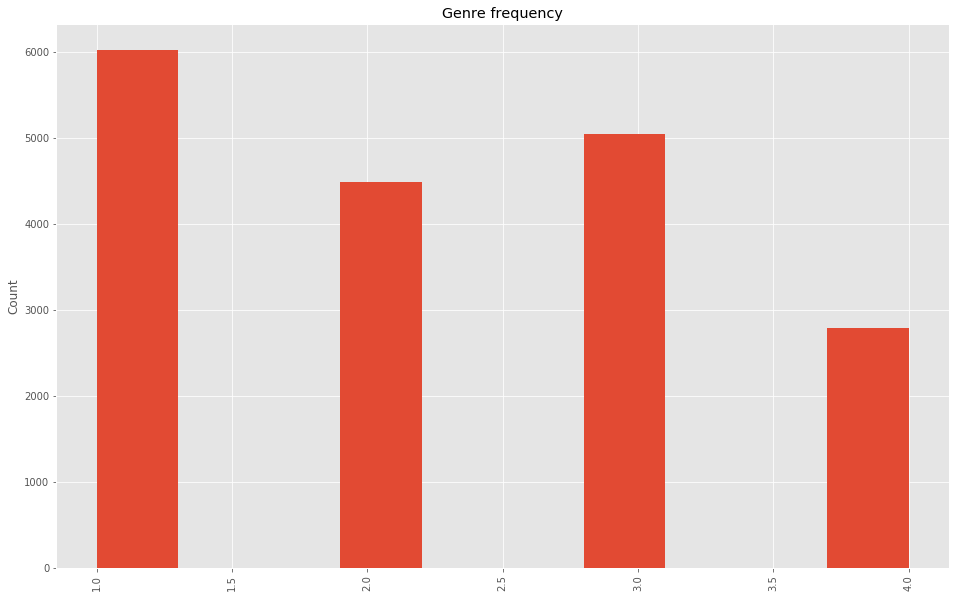

In [205]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(rotation=90)
plt.show()

# Subset to make model less time-consuming

In [207]:
df = shuffle(df)
df = df[:200]

In [208]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['artist_name','track_name','track_id','Unnamed: 0.1'],axis = 1)
mat = mat.values

In [209]:
#re-enumrate track ids
i = 0
for i in range(len(mat)):
    mat[i,0] = i+1
mat[:,0]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

# Baseline model with sklearn

In [219]:
X = mat[:,1:-1].astype("float")
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
#ind = mat[:,0].astype("int")
ind = mat[:,0].astype("int")

(200, 14)
(200,)


In [221]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [222]:
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 160
num test: 40


In [223]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("Predictions:", y_hat)
print("True values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Predictions: [2 2 3 1 2 1 2 1 3 2 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 1 3 1 1 3 2 1 1 2 1 1 1
 3 1 3]
True values: [2 2 3 1 3 1 2 4 3 3 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 4 3 1 1 3 2 1 1 1 1 1 1
 3 4 3]
Accuracy: 0.85


## Hierarchical logistic regression in STAN

Our dataset consists of multiple observations from various tracks. However, when we build our original logistic regression in STAN, our specification assumes that all tracks share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all tracks are equally biased towards a given genre (e.g. pop). This is obviously a very strong assumption. We should allow different tracks to have different biases (alpha).

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global mean parameters $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global variance parameters $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. For each track $i \in \{1,\dots,I\}$
        4. Draw $\beta_{i,c}$ such that $\beta_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$
    6. For each track $i \in \{1,\dots,I\}$
        5. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the track identifier for track $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

In [272]:
# define Stan model
model_definition = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int ind[N];
    matrix[N,D] X;
    int<lower=1,upper=C> y[N];
}

parameters {
    vector<lower=1>[C] mu_prior;
    vector<lower=1>[C] sigma_prior;
    
    matrix[I,C] alpha;
    matrix[C,D] beta;  
    
    
    
}

model {
    for (c in 1:C) {
        mu_prior[c] ~ normal(c,0.5);
        sigma_prior[c] ~ cauchy(c,0.5);
        
        beta[c,1] ~ beta(0,1); //popularity
        beta[c,2] ~ beta(0,1); //acousticness
        beta[c,3] ~ beta(0,1); //danceability
        beta[c,4] ~ normal(0,10); //duration
        beta[c,5] ~ beta(0,1); //energy
        beta[c,6] ~ beta(0,1); //instrumentalness
        beta[c,7] ~ normal(0,10); //key - should be categorical...
        beta[c,8] ~ normal(0.1,0.2); //liveness
        beta[c,9] ~ normal(0,10); //loudness
        beta[c,10] ~ normal(0,10); //mode - should be binomial...
        beta[c,11] ~ normal(0.1,0.2); //speechiness
        beta[c,12] ~ normal(0,10); //tempo
        beta[c,13] ~ beta(0,1); //time_signature
        beta[c,14] ~ normal(0.4,0.8); //valence
        
        
        for (i in 1:I){
            alpha[i,c] ~ normal(mu_prior[c],sigma_prior[c]);
        }
    }
    for (n in 1:N){
        y[n] ~ categorical(softmax(alpha[ind[n],:]' + beta * X[n]'));
        
    }    
}
"""

# Questions regarding the model...

1. Do we set different mu and sigma for each class C? We observed that different mu for each class results in a higher accuracy (we get approximately +8% accuracy doing this...) 
2. How do we define beta parameters? 
3. How do we find a proper distribution for e.g. popularity (which is a mixture of exponential/normal)?
4. How do we make distributions dependent on other distributions? 
5. We cant make beta[c,10] follow a binomial distribution because it expects beta to be an int (it is real in this case...). 
6. When compiling the model, we get the error: "Initialization between (-2, 2) failed after 100 attempts. Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.". How does one fix this? 
7. Why do we standardize the data? And should we make priors for the standardized data (or how is looked before)? 

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [273]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=160, D=14, C=4, I=200


In [274]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

ValueError: Failed to parse Stan model 'anon_model_ba5402c35919680e1a6773fc31fb100f'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

parameters or transformed parameters cannot be integer or integer array;  found declared type int, parameter name=beta
Problem with declaration.
  error in 'unknown file name' at line 18, column 18
  -------------------------------------------------
    16:     matrix[I,C] alpha;
    17:     //matrix[C,D] beta;  
    18:     int beta[C,D];
                         ^
    19:     
  -------------------------------------------------



Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

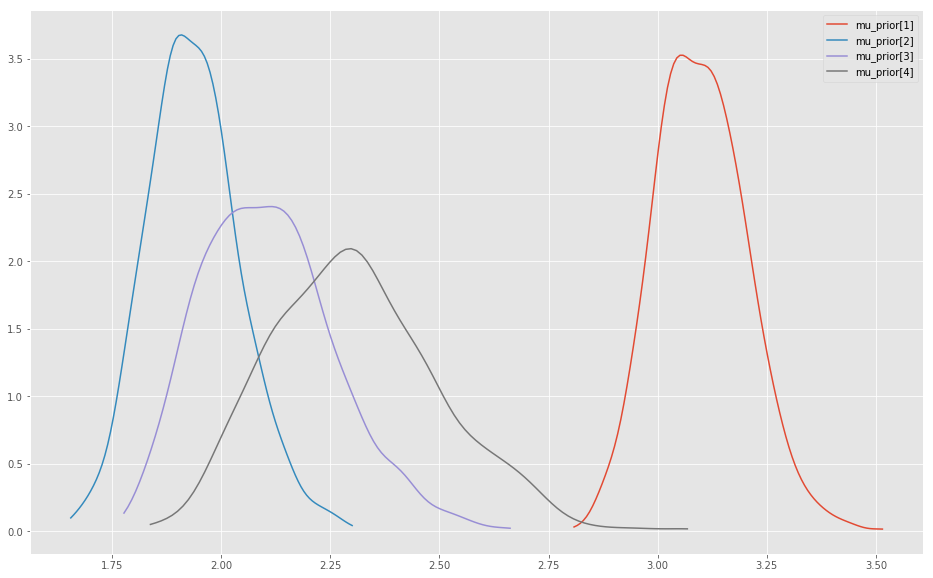

In [234]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

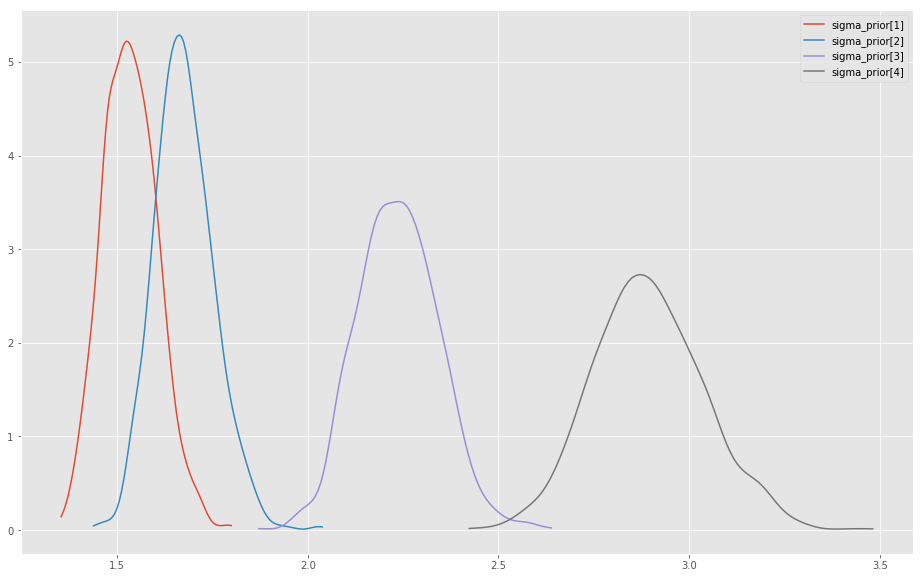

In [235]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [236]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per track. 

In [237]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 3 1 2 1 2 1 3 2 3 1 2 3 2 1 1 1 3 2 3 1 3 3 2 1 3 1 1 3 2 2 1 1 2 3 1
 3 4 3]
true values: [2 2 3 1 3 1 2 4 3 3 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 4 3 1 1 3 2 1 1 1 1 1 1
 3 4 3]
Accuracy: 0.8


# Working model with wrong hyper-priors...
Below is a working model in STAN with accuracy around 80% but with the wrong hyper-priors because the model fails otherwise...

In [277]:
# define Stan model
model_definition = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int ind[N];
    matrix[N,D] X;
    int<lower=1,upper=C> y[N];
}

parameters {
    vector<lower=1>[C] mu_prior;
    vector<lower=1>[C] sigma_prior;
    
    matrix[I,C] alpha;
    matrix[C,D] beta;  
    
    
    
}

model {
    for (c in 1:C) {
        mu_prior[c] ~ normal(c,0.5);
        sigma_prior[c] ~ normal(c,0.5);
        
        beta[c,1] ~ normal(0,0.5); //popularity
        beta[c,2] ~ normal(0.5,0.5); //acousticness
        beta[c,3] ~ normal(0.5,0.25); //danceability
        beta[c,4] ~ cauchy(0,0.5); //duration
        beta[c,5] ~ normal(0,0.5); //energy
        beta[c,6] ~ cauchy(0,1); //instrumentalness
        beta[c,7] ~ normal(0,0.5); //key
        beta[c,8] ~ cauchy(0.1,0.2); //liveness
        beta[c,9] ~ cauchy(0,0.5); //loudness
        beta[c,10] ~ normal(0.5,0.5); //mode
        beta[c,11] ~ cauchy(0.1,0.2); //speechiness
        beta[c,12] ~ normal(120,50); //tempo
        beta[c,13] ~ normal(0,0.5); //time_signature
        beta[c,14] ~ cauchy(0.4,0.8); //valence
        
        
        for (i in 1:I){
            alpha[i,c] ~ normal(mu_prior[c],sigma_prior[c]);
        }
    }
    for (n in 1:N){
        y[n] ~ categorical(softmax(alpha[ind[n],:]' + beta * X[n]'));
        
    }    
}
"""

In [278]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=160, D=14, C=4, I=200


In [279]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7f3a42cecfb931cfe1c3618dfa44a70 NOW.


Wall time: 1min 16s


In [280]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 3 1 2 1 2 1 3 2 3 1 2 3 2 1 1 1 3 2 3 1 3 3 2 1 3 1 1 3 2 2 1 1 2 3 1
 3 4 3]
true values: [2 2 3 1 3 1 2 4 3 3 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 4 3 1 1 3 2 1 1 1 1 1 1
 3 4 3]
Accuracy: 0.8
